In [1]:
# Core libraries and model APIs
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

sns.set_theme(style="whitegrid", palette="deep")
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
# Load and tidy the engineered feature sheet
ctg_path = Path("ctg.xlsx")
assert ctg_path.exists(), f"Expected Excel file at {ctg_path.resolve()}"

def read_feature_sheet(path: Path, sheet=0):
    """Load the CTG feature sheet, using row 2 as headers and data from row 3 onward."""
    xls = pd.ExcelFile(path)
    sheet_name = xls.sheet_names[sheet] if isinstance(sheet, int) else sheet
    try:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
    except ValueError:
        df = pd.read_excel(xls, sheet_name=sheet_name, header=0)
    return df

raw_features = read_feature_sheet(ctg_path, sheet=1)
raw_features.shape

(2129, 46)

In [3]:
def tidy_sheet(df: pd.DataFrame) -> pd.DataFrame:
    cleaned = df.copy()
    cleaned.columns = [str(col).strip() for col in cleaned.columns]
    cleaned = cleaned.dropna(axis=0, how='all').dropna(axis=1, how='all')
    cleaned = cleaned.loc[:, ~cleaned.columns.str.contains('^Unnamed', case=False)]
    cleaned = cleaned.loc[:, ~cleaned.columns.duplicated()]
    rename_map = {
        'MSTV': 'mSTV',
        'MLTV': 'mLTV',
        'Variance ': 'Variance',
        'TENDENCY': 'Tendency'
    }
    cleaned = cleaned.rename(columns={k: v for k, v in rename_map.items() if k in cleaned.columns})
    return cleaned

# --- Apply tidying ---
sheet2 = tidy_sheet(raw_features)
target_col = 'NSP'
label_leak_cols = ['CLASS', 'A', 'B', 'C', 'D', 'E', 'AD', 'DE', 'LD', 'FS', 'SUSP']
feature_cols = [col for col in sheet2.columns if col not in label_leak_cols + [target_col]]

# --- Row-loss audit ---
row_counts = {}

# Initial count
row_counts['initial'] = sheet2.shape[0]

# Drop leakage + empty rows + duplicates
step1 = (
    sheet2
    .drop(columns=label_leak_cols)
    .dropna(axis=0, how='all')
    .drop_duplicates()
)
row_counts['after_drop_leak_dup'] = step1.shape[0]

# Coerce numerics
numeric_cols = feature_cols
step1[numeric_cols] = step1[numeric_cols].apply(pd.to_numeric, errors='coerce')
row_counts['after_coerce_numeric'] = step1.shape[0]  # same rows, but some values may have become NaN

# Drop rows with Nan in NSP column
step2 = step1.dropna(subset=[target_col]).copy()
step2[target_col] = step2[target_col].astype(int)
row_counts['after_drop_missing_target'] = step2.shape[0]

# Final clean data
clean_df = step2.copy()
X = clean_df[numeric_cols]
y = clean_df[target_col]

# --- Print audit summary ---
print("Row-loss audit:")
for step, count in row_counts.items():
    print(f"{step}: {count} rows")

print("\nClass distribution (final):")
print(y.value_counts().sort_index())


Row-loss audit:
initial: 2128 rows
after_drop_leak_dup: 2117 rows
after_coerce_numeric: 2117 rows
after_drop_missing_target: 2115 rows

Class distribution (final):
NSP
1    1647
2     293
3     175
Name: count, dtype: int64


In [4]:
clean_df

,b,e,AC,FM,UC,DL,DS,DP,DR,LB,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,240.00,357.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,120.00,...,62.00,126.00,2.00,0.00,120.00,137.00,121.00,73.00,1.00,2
1,5.00,632.00,4.00,0.00,4.00,2.00,0.00,0.00,0.00,132.00,...,68.00,198.00,6.00,1.00,141.00,136.00,140.00,12.00,0.00,1
2,177.00,779.00,2.00,0.00,5.00,2.00,0.00,0.00,0.00,133.00,...,68.00,198.00,5.00,1.00,141.00,135.00,138.00,13.00,0.00,1
3,411.00,"1,192.00",2.00,0.00,6.00,2.00,0.00,0.00,0.00,134.00,...,53.00,170.00,11.00,0.00,137.00,134.00,137.00,13.00,1.00,1
4,533.00,"1,147.00",4.00,0.00,5.00,0.00,0.00,0.00,0.00,132.00,...,53.00,170.00,9.00,0.00,137.00,136.00,138.00,11.00,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2121,"2,059.00","2,867.00",0.00,0.00,6.00,0.00,0.00,0.00,0.00,140.00,...,137.00,177.00,4.00,0.00,153.00,150.00,152.00,2.00,0.00,2
2122,"1,576.00","2,867.00",1.00,0.00,9.00,0.00,0.00,0.00,0.00,140.00,...,103.00,169.00,6.00,0.00,152.00,148.00,151.00,3.00,1.00,2
2123,"1,576.00","2,596.00",1.00,0.00,7.00,0.00,0.00,0.00,0.00,140.00,...,103.00,170.00,5.00,0.00,153.00,148.00,152.00,4.00,1.00,2
2124,"1,576.00","3,049.00",1.00,0.00,9.00,0.00,0.00,0.00,0.00,140.00,...,103.00,169.00,6.00,0.00,152.00,147.00,151.00,4.00,1.00,2


In [5]:
# --- 1. Train/test split with stratification ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,          # 30% of data reserved for testing
    random_state=42,        # reproducibility
    stratify=y              # preserve class distribution in both splits
)

# --- 2. Compute class weights (to handle imbalance) ---
classes = np.unique(y_train)    # get unique classes (1, 2, 3)
class_weight_values = compute_class_weight(
    class_weight='balanced',    # balance weights based on frequency
    classes=classes,
    y=y_train
)
class_weight_dict = dict(zip(classes, class_weight_values))
# dictionary mapping {class_label: weight}

# --- 3. Compute sample weights (row-level weights) ---
sample_weight_train = compute_sample_weight(
    class_weight='balanced', y=y_train
)
# each training row gets a weight proportional to its class frequency

# --- 4. Summarize distribution of splits ---
distribution = (
    pd.DataFrame({
        'Split': ['Train', 'Test'],
        'Size': [len(y_train), len(y_test)],               # number of samples
        'Normal (1)': [np.mean(y_train == 1), np.mean(y_test == 1)],
        'Suspect (2)': [np.mean(y_train == 2), np.mean(y_test == 2)],
        'Pathologic (3)': [np.mean(y_train == 3), np.mean(y_test == 3)]
        # compute class proportions in each split
    })
    .rename(columns=lambda c: c if c in {'Split', 'Size'} else f'{c} proportion')
)

# --- 5. Output: class distribution and weights ---
distribution, class_weight_dict


(   Split  Size  Normal (1) proportion  Suspect (2) proportion  \
 0  Train  1480                   0.78                    0.14   
 1   Test   635                   0.78                    0.14   
 
    Pathologic (3) proportion  
 0                       0.08  
 1                       0.08  ,
 {1: 0.4278693263949118, 2: 2.4065040650406506, 3: 4.043715846994536})

In [6]:
from sklearn.metrics import (
    recall_score,
    classification_report,
    balanced_accuracy_score,
    f1_score,
    ConfusionMatrixDisplay
)


results = []

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test, fit_kwargs=None, display_report=False):
    fit_kwargs = fit_kwargs or {}
    estimator.fit(X_train, y_train, **fit_kwargs)
    y_pred = estimator.predict(X_test)

    # Standard metrics
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results.append({'Model': name, 'Balanced Accuracy': bal_acc, 'F1 Macro': f1})
    print(f"{name} — Balanced Accuracy: {bal_acc:.3f}, Macro F1: {f1:.3f}")

    # NSP=3 recall
    recall_nsp3 = recall_score(y_test, y_pred, labels=[3], average='macro', zero_division=0)
    print(f"NSP 3 Recall: {recall_nsp3:.3%}")

    # NSP=3 misclassified as NSP=1
    true_nsp3 = (y_test == 3)
    if true_nsp3.sum() > 0:
        nsp3_as1 = np.sum((y_test == 3) & (y_pred == 1))
        mis_as1_pct = nsp3_as1 / true_nsp3.sum()
        print(f"NSP 3 → predicted as NSP 1: {mis_as1_pct:.3%}")
    else:
        print("No NSP 3 samples in test set.")

    # Optional detailed report
    if display_report:
        print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=sorted(classes), normalize='true', cmap='Blues'
    )
    disp.ax_.set_title(f"{name} — Normalized Confusion Matrix")
    plt.show()

    return estimator, y_pred
classes

array([1, 2, 3])

Neural Network (MLP) — Balanced Accuracy: 0.756, Macro F1: 0.792
NSP 3 Recall: 64.151%
NSP 3 → predicted as NSP 1: 9.434%


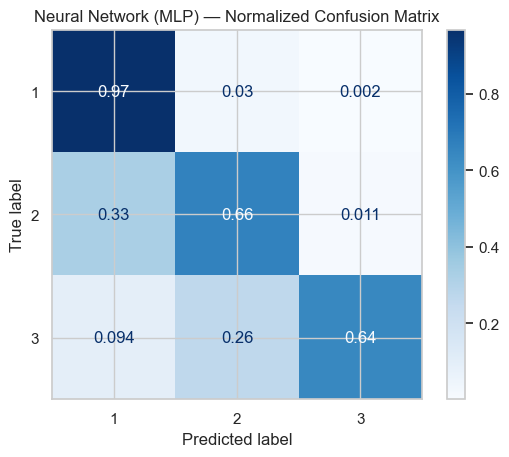

In [7]:
mlp_1layer_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_1layer_pipeline, X_train, y_train, X_test, y_test)

Neural Network (MLP) — Balanced Accuracy: 0.801, Macro F1: 0.832
NSP 3 Recall: 73.585%
NSP 3 → predicted as NSP 1: 7.547%


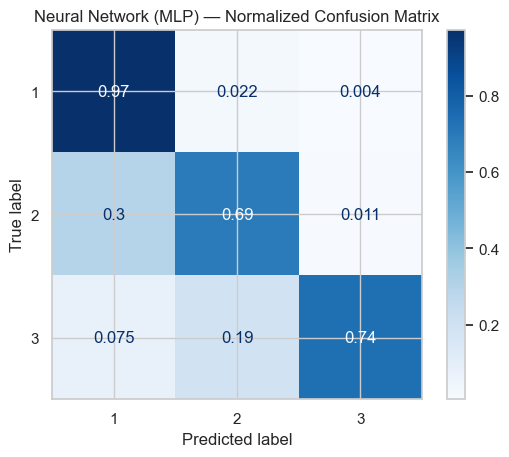

In [8]:
mlp_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        alpha=1e-3,
        learning_rate='adaptive',
        max_iter=1000,
        early_stopping=True,
        random_state=42
    ))
])
_ = evaluate_model('Neural Network (MLP)', mlp_pipeline, X_train, y_train, X_test, y_test)

Random Forest — Balanced Accuracy: 0.911, Macro F1: 0.909
NSP 3 Recall: 90.566%
NSP 3 → predicted as NSP 1: 3.774%


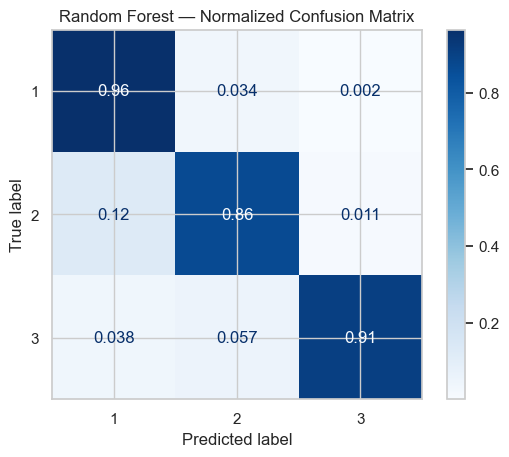

In [9]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        max_features = 'sqrt'
    ))
])
_ = evaluate_model('Random Forest', rf_pipeline, X_train, y_train, X_test, y_test)

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import numpy as np

# Define pipeline with imputation + RF
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Define parameter space for RandomizedSearch
param_dist = {
    'rf__n_estimators': randint(200, 600),       # number of trees
    'rf__max_depth': [None, 10, 20, 30, 50],     # tree depth
    'rf__min_samples_split': [2, 5, 10],         # min split
    'rf__min_samples_leaf': [1, 2, 4, 5],        # min leaf
    'rf__max_features': ['sqrt', 'log2', 0.5],   # feature subsampling
}

# Randomized search (try ~50 configs, adjust n_iter for speed/accuracy)
search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring='f1_macro',    # use macro-F1 since classes are imbalanced
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit search
search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best CV Macro-F1:", search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'rf__max_depth': None, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 330}
Best CV Macro-F1: 0.8976848988500802


In [25]:
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

# Custom scorer: minimize false negatives for NSP=3
def nsp3_fn_rate(y_true, y_pred):
    """
    Returns negative false negative rate for NSP=3
    (higher score = fewer false negatives).
    """
    cm = confusion_matrix(y_true, y_pred, labels=[1,2,3])
    fn = cm[2, :].sum() - cm[2, 2]   # all true NSP=3 but not predicted as 3
    tp = cm[2, 2]                   # true positives (correct NSP=3)
    total = fn + tp
    if total == 0:
        return 0.0  # no NSP=3 in this fold
    fnr = fn / total
    return -fnr   # negative so lower FNR = higher score

nsp3_scorer = make_scorer(nsp3_fn_rate)

# Randomized search prioritizing NSP=3 false negatives
search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    scoring=nsp3_scorer,   # 👈 use custom scorer
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best parameters (minimizing NSP=3 FN):", search.best_params_)
print("Best CV score (negative FNR):", search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters (minimizing NSP=3 FN): {'rf__max_depth': 50, 'rf__max_features': 0.5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 528}
Best CV score (negative FNR): -0.082


Random Forest (FN-optimized) — Balanced Accuracy: 0.904, Macro F1: 0.908
NSP 3 Recall: 92.453%
NSP 3 → predicted as NSP 1: 3.774%


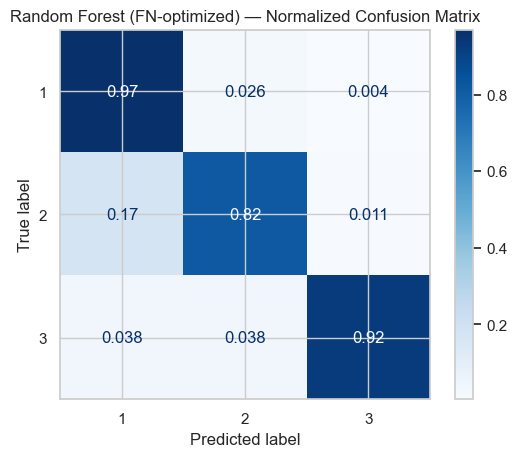

In [27]:
rf_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=528,        # best param
        max_depth=50,            # best param
        min_samples_leaf=4,      # best param
        min_samples_split=2,     # best param
        max_features=0.5,        # best param
        class_weight='balanced', # keep balancing for imbalanced data
        random_state=42,
        n_jobs=-1
    ))
])

# Evaluate with your custom function
_ = evaluate_model('Random Forest (FN-optimized)', rf_pipeline, X_train, y_train, X_test, y_test)
